<a href="https://colab.research.google.com/github/Shabbir07/IBM-Capstone-Project/blob/master/Battle_of_the_Neighborhoods_my_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exploring New York City's Diverse Food Cultures for Tourism Purposes

## IBM Data Science Professional Certificate - Capstone Project

### Shabbir Ahmad

# Problem Statement

Tourism industry in the city is in boom for over a decade. The city welcomed over 65 million tourists in 2019 which included over 13 million foreign tourists (NYC and Company, 2020). While visiting different sites, tourists often find it difficult to find the restaurants and eateries of their choice in those areas. For instance, in some neighbourhoods, there are numerous outlets for Italian and Chinese food but there might be only one or no Mexican or Caribbean restaurants. Moreover, sometimes the tourists are also overwhelmed by the food choices and the decision-making process may be time consuming. 
In this project, I aim to explore all the boroughs of New York City and locate all the possible food options in specific areas and neighbourhoods of the city. Eateries for different food categories and cuisine belonging to different ethnic groups and countries will be located in the city. 


## Data Requirement

Data related to boroughs (including neighbourhoods) of New York City will be required. The Foursquare API will be used to extract data for different locations of the city. I will need address, latitude and longitude of the locations mainly. To create data frames and analyse data, I will use different libraries like pandas, numpy, matplotlib and folium (for mapping). 

•	New York City dataset: This dataset will provide the addresses of neighbourhoods of the city. A json file will be extracted from here.  https://geo.nyu.edu/catalog/nyu_2451_34572 

•	Foursquare API: It is a location data provider and will be used to make API calls to extract data regarding different venues in New York City’s neighbourhoods. To access the API, ‘CLIENT_ID’, ‘CLIENT_SECRET’ and ‘VERSION’ will be defined.
https://developer.foursquare.com/docs/ 


## Methodology

First we need to import all the necessary libraries

In [0]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files
from pprint import pprint # data pretty printer

import requests # library to handle requests
from bs4 import BeautifulSoup  # library to handle web scraping

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import matplotlib.cm as cm # Matplotlib and associated plotting modules
import matplotlib.colors as colors # Matplotlib and associated plotting modules

from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

from collections import Counter # count occurrences 

from sklearn.cluster import KMeans # import k-means from clustering stage

We'll need folium later for generating maps. 

In [0]:
!conda install -c conda-forge folium=0.5.0 --yes

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - folium=0.5.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    certifi-2020.4.5.1         |   py36h9f0ad1d_0         151 KB  conda-forge
    vincent-0.4.4              |             py_1          28 KB  conda-forge
    folium-0.5.0               |             py_0          45 KB  conda-forge
    ca-certificates-2020.4.5.1 |       hecc5488_0         146 KB  conda-forge
    altair-4.1.0               |             py_1         614 KB  conda-forge
    python_abi-3.6             |          1_cp36m           4 KB  conda-forge
    branca-0.4.0               |             py_0          26 KB  conda-forge
    openssl-1.1.1g             |       h516909a_0         2.1 MB  conda-forge
    ------------------------------------------------------------
                       

In [0]:
import folium

Now, its time to download New York City dataset. The dataset contains 05 boroughs and the neighbourhoods of the city. We'll segment these into clusters later. 

In [0]:
!wget -q -O 'newyork_data.json' https://cocl.us/new_york_dataset
print('Data downloaded!')

Data downloaded!


In [0]:
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)

The URL returns the .json file containing the dataset in the form of a python dictionary. The requisite data i.e. the list of five boroughs and the neighbourhoods within these boroughs, is in the features key. 

In [0]:
print ("newyork_data key and value's length are: ") 
for key, value in newyork_data.items(): 
    print (key, len(str(value)))

newyork_data key and value's length are: 
type 17
totalFeatures 3
features 124743
crs 70
bbox 74


Defining a new variable that includes this data.

In [0]:
neighborhoods_data = newyork_data['features']
pprint(neighborhoods_data[305])

{'geometry': {'coordinates': [-74.08173992211962, 40.61731079252983],
              'type': 'Point'},
 'geometry_name': 'geom',
 'id': 'nyu_2451_34572.306',
 'properties': {'annoangle': 0.0,
                'annoline1': 'Fox',
                'annoline2': 'Hills',
                'annoline3': None,
                'bbox': [-74.08173992211962,
                         40.61731079252983,
                         -74.08173992211962,
                         40.61731079252983],
                'borough': 'Staten Island',
                'name': 'Fox Hills',
                'stacked': 2},
 'type': 'Feature'}


Now the data will be transformed into pandas dataframe 

In [0]:
# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)
neighborhoods

,Borough,Neighborhood,Latitude,Longitude


Looping through the data and filling the dataframe.

In [0]:
for data in neighborhoods_data:
    borough = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

In [0]:
neighborhoods.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [0]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(neighborhoods['Borough'].unique()),
        neighborhoods.shape[0]
    )
)

The dataframe has 5 boroughs and 306 neighborhoods.


Its time to get the latitude and longitude values of New York City through Geopy library

In [0]:
address = 'New York City, NY'
location = None

# define an instance of the geocoder -> ny_explorer
while location == None:
    try:
        geolocator = Nominatim(user_agent="ny_explorer")
        location = geolocator.geocode(address)
        latitude = location.latitude
        longitude = location.longitude
    except:
        pass
print('The geograpical coordinate of New York City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of New York City are 40.7127281, -74.0060152.


Now we can create a map of the New York City through folium. We have already imported folium so we can execute the code right away.

In [0]:
# create map of New York using latitude and longitude values
map_newyork = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(neighborhoods['Latitude'], neighborhoods['Longitude'], neighborhoods['Borough'], neighborhoods['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_newyork)  
    
map_newyork

As mentioned in the beginning of this notebook, we need credentials like CLIENT ID, CLIENT SECRET AND VERSION to access Foursquare API. So, lets define these credentials. 

In [0]:
CLIENT_ID = 'AT5C50MTJUNECDNJA2C3MFNQZCIRL2TCNPJYNSNTJ1XZBYW4' # your Foursquare ID
CLIENT_SECRET = 'VC2QFA1QM11CGVNQM2I3MBA34KL5NED1YKIGBWHCNZZBZJWG' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: AT5C50MTJUNECDNJA2C3MFNQZCIRL2TCNPJYNSNTJ1XZBYW4
CLIENT_SECRET:VC2QFA1QM11CGVNQM2I3MBA34KL5NED1YKIGBWHCNZZBZJWG


The venue category hierarchy will be fetched now.

In [0]:
url = 'https://api.foursquare.com/v2/venues/categories?&client_id={}&client_secret={}&v={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION)
category_results = requests.get(url).json()

Structure of the keys can be observed through executing the following code.

In [0]:
for key, value in category_results['response']['categories'][0].items():
    print(key, len(str(value)))

id 24
name 20
pluralName 20
shortName 20
icon 98
categories 15910


In [0]:
category_list = category_results['response']['categories']

In [0]:
len(category_list)

10

In [0]:
for data in category_list:
    print(data['id'], data['name'])

4d4b7104d754a06370d81259 Arts & Entertainment
4d4b7105d754a06372d81259 College & University
4d4b7105d754a06373d81259 Event
4d4b7105d754a06374d81259 Food
4d4b7105d754a06376d81259 Nightlife Spot
4d4b7105d754a06377d81259 Outdoors & Recreation
4d4b7105d754a06375d81259 Professional & Other Places
4e67e38e036454776db1fb3a Residence
4d4b7105d754a06378d81259 Shop & Service
4d4b7105d754a06379d81259 Travel & Transport


As we can see above, we got 10 different categories but we only need one category, i.e. Food. We will also need its sub-categories. 

A function will be created to return the dictionary with IDs and names of the category and its sub-categories. 

In [0]:
# function to flatten a 'parent_id' category, returns all categories if checkParentID = False
def flatten_Hierarchy(category_list, checkParentID, category_dict, parent_id = ''):
    for data in category_list:
        
        if checkParentID == True and data['id'] == parent_id:
            category_dict[data['id']] = data['name']
            flatten_Hierarchy(category_list = data['categories'], checkParentID = False, category_dict = category_dict)
        
        elif checkParentID == False:
            category_dict[data['id']] = data['name']
            if len(data['categories']) != 0:
                flatten_Hierarchy(category_list = data['categories'], checkParentID = False, category_dict = category_dict)
    
    return category_dict

In [0]:
# The following function will take the parent ID and returns 'name' and 'id' of all the sub-categories
category_dict = flatten_Hierarchy(category_list, checkParentID=True, category_dict = {}, parent_id = '4d4b7105d754a06374d81259')

Now we can check if we are on the right path. To do this, we can explore the first neighbourhood and see the results. 

In [0]:
neighborhoods.loc[0, 'Neighborhood']

'Wakefield'

Now the neighborhood's latitude and longitude values will be determined.

In [0]:
neighborhood_latitude = neighborhoods.loc[0, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = neighborhoods.loc[0, 'Longitude'] # neighborhood longitude value

neighborhood_name = neighborhoods.loc[0, 'Neighborhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Wakefield are 40.89470517661, -73.84720052054902.


We can set a radius of 500 meters for the neighborhoods. For the first neighborhood (Wakefield) we can get the food venues within this radius by creating a GET request URL. 

In [0]:
LIMIT = 1 # limit of number of venues returned by Foursquare API
radius = 500 # define radius
categoryId = '4d4b7105d754a06374d81259' # category ID for "Food"

# create URL

url = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&categoryId={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius,
    categoryId,
    LIMIT)
url # display URL

'https://api.foursquare.com/v2/venues/search?&client_id=AT5C50MTJUNECDNJA2C3MFNQZCIRL2TCNPJYNSNTJ1XZBYW4&client_secret=VC2QFA1QM11CGVNQM2I3MBA34KL5NED1YKIGBWHCNZZBZJWG&v=20180605&ll=40.89470517661,-73.84720052054902&radius=500&categoryId=4d4b7105d754a06374d81259&limit=1'

Now the GET request will be executed and the results will be examined. 

In [0]:
results = requests.get(url).json()

In [0]:
results['response']['venues']

[{'id': '4c783cef3badb1f7e4244b54',
  'name': 'Carvel Ice Cream',
  'location': {'address': '1006 E 233rd St',
   'lat': 40.890486685759605,
   'lng': -73.84856772568665,
   'labeledLatLngs': [{'label': 'display',
     'lat': 40.890486685759605,
     'lng': -73.84856772568665},
    {'label': 'entrance', 'lat': 40.890438, 'lng': -73.848559}],
   'distance': 483,
   'postalCode': '10466',
   'cc': 'US',
   'city': 'Bronx',
   'state': 'NY',
   'country': 'United States',
   'formattedAddress': ['1006 E 233rd St',
    'Bronx, NY 10466',
    'United States']},
  'categories': [{'id': '4bf58dd8d48988d1c9941735',
    'name': 'Ice Cream Shop',
    'pluralName': 'Ice Cream Shops',
    'shortName': 'Ice Cream',
    'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/icecream_',
     'suffix': '.png'},
    'primary': True}],
  'referralId': 'v-1588011540',
  'hasPerk': False}]

The category name of the venue 'Carvel Ice Cream' is 'Food'.

Now its time to extract data from all the 306 neighborhoods' venues. 

A function can be created to repeat the following process to all the neighborhoods in NYC:

Create the API request URL with radius=500, LIMIT=100
Make the GET request
All nearby values will be added to a list. This list will be unfolded and added to the dataframe. 

Creating a comma seperated string from category_dict.

In [0]:
categoryId_list = []
for key, value in category_dict.items():
    categoryId_list.append(key)
categoryId = ','.join(categoryId_list)

As mentioned earlier, there are 306 neighborhoods in New York City and to segment the neighborhoods, fetching data from all the neighborhoods is necessary. However, it is laborious to repeat the process for these neighborhoods individually. To make this process easier, a new function ‘getNearbyFood’ is created. This function loops through all the neighborhoods of New York City and creates an API request URL with radius = 500, LIMIT = 100. Limit is set to 100, so that a maximum of 100 venues are returned in the vicinity. 

In [0]:
def getNearbyFood(names, latitudes, longitudes, radius=1000, LIMIT=500):
    not_found = 0
    print('***Start ', end='')
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(' .', end='')
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&categoryId={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius,
            "4d4b7105d754a06374d81259", # "Food" category id
            LIMIT)
            
        try:
            # make the GET request
            results = requests.get(url).json()['response']['venues']
            
            # return only relevant information for each nearby venue
            venues_list.append([(
                name, 
                lat, 
                lng, 
                v['name'], 
                v['location']['lat'], 
                v['location']['lng'],  
                v['categories'][0]['name']) for v in results])
        except:
            not_found += 1
    
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    print("\nDone*** with {} venues with incompelete information.".format(not_found))
    return(nearby_venues)

It is evident that the data obtained for all the 306 neighborhoods is a large amount of information and it may need some organization. To serialize this information, ‘Pickle’ library is used. However, we may need to deserialize it again later because it will be necessary for retrieving an exact python object structure. 

In [0]:
import pickle # to serialize and deserialize a Python object structure
try:
    with open('nyc_food_venues.pkl', 'rb') as f:
        nyc_venues = pickle.load(f)
    print("---Dataframe Existed and Deserialized---")
except:
    nyc_venues = getNearbyFood(names=neighborhoods['Neighborhood'],
                                        latitudes=neighborhoods['Latitude'],
                                        longitudes=neighborhoods['Longitude']
                                       )
    with open('nyc_food_venues.pkl', 'wb') as f:
        pickle.dump(nyc_venues, f)
    print("---Dataframe Created and Serialized---")

***Start  . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Done*** with 0 venues with incompelete information.
---Dataframe Created and Serialized---


## Data Analysis 
First we need to check the size of the dataframe in question and see the first five rows of the dataframe 'nyc_venues'


In [0]:
print(nyc_venues.shape)

(13612, 7)


In [0]:
nyc_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Wakefield,40.894705,-73.847201,Central Deli,40.896728,-73.844387,Deli / Bodega
1,Wakefield,40.894705,-73.847201,Carvel Ice Cream,40.890487,-73.848568,Ice Cream Shop
2,Wakefield,40.894705,-73.847201,Dunkin',40.890459,-73.849089,Donut Shop
3,Wakefield,40.894705,-73.847201,Cooler Runnings Jamaican Restaurant Inc,40.898083,-73.850259,Caribbean Restaurant
4,Wakefield,40.894705,-73.847201,SUBWAY,40.890468,-73.849152,Sandwich Place


Determining the number of unique categories 

In [0]:
print('There are {} uniques categories.'.format(len(nyc_venues['Venue Category'].unique())))
nyc_venues.groupby('Venue Category')['Venue Category'].count().sort_values(ascending=False)

There are 187 uniques categories.


Venue Category
Deli / Bodega                               1341
Pizza Place                                 1184
Coffee Shop                                  767
Bakery                                       630
Fast Food Restaurant                         623
Chinese Restaurant                           617
Donut Shop                                   611
Italian Restaurant                           485
Bagel Shop                                   409
Mexican Restaurant                           377
Fried Chicken Joint                          354
Caribbean Restaurant                         350
American Restaurant                          329
Café                                         314
Sandwich Place                               300
Diner                                        260
Restaurant                                   257
Food                                         251
Ice Cream Shop                               225
Burger Joint                                 214
Food 

## Data Cleaning 

This project is aimed at locating diverse cuisine in New York City and make it easier for the tourists to find the eatery of their choice. So far in the data analysis, I have identified 187 categories of ‘Food’ but these also include general categories like coffee shops, ice cream shops, cafes and so on. These categories are common across different cultures and do not need to be identified in this analysis which is why these will be eliminated to refine the data. A list of these ‘general’ categories is compiled and then subtracted from the list of unique categories. It will give us the categories of our interest. After these steps, we are left with 101 unique categories in comparison to 187 categories before data cleaning. 


In [0]:
# Now its time to list all the categories
unique_categories = nyc_venues['Venue Category'].unique().tolist()
print(', '.join(str(x) for x in unique_categories))

Deli / Bodega, Ice Cream Shop, Donut Shop, Caribbean Restaurant, Sandwich Place, Fried Chicken Joint, Fast Food Restaurant, Comfort Food Restaurant, Food, Bakery, Latin American Restaurant, Pizza Place, Diner, Burger Joint, Spanish Restaurant, Chinese Restaurant, Southern / Soul Food Restaurant, Restaurant, Food Truck, Mexican Restaurant, Bagel Shop, Seafood Restaurant, Juice Bar, Steakhouse, BBQ Joint, American Restaurant, Italian Restaurant, Coffee Shop, Grocery Store, Wings Joint, Asian Restaurant, Breakfast Spot, Café, African Restaurant, Sushi Restaurant, Japanese Restaurant, Bar, New American Restaurant, Empanada Restaurant, Vegetarian / Vegan Restaurant, Greek Restaurant, Cuban Restaurant, Pub, Falafel Restaurant, Salvadoran Restaurant, Indian Restaurant, Soup Place, Cupcake Shop, Other Nightlife, Arcade, Food Court, Taco Place, Eastern European Restaurant, Health Food Store, Frozen Yogurt Shop, French Restaurant, Tapas Restaurant, Convenience Store, Food & Drink Shop, Supermark

In [0]:
# creating a list of generalized categories
general_categories = ['Dessert Shop','Food','Ice Cream Shop','Donut Shop','Bakery','Sandwich Place','Comfort Food Restaurant',
                    'Deli / Bodega','Food Truck','Bagel Shop','Burger Joint','Restaurant','Frozen Yogurt Shop','Coffee Shop',
                    'Diner','Wings Joint','Café','Juice Bar','Breakfast Spot','Grocery Store','Bar','Cupcake Shop',
                    'Pub','Fish & Chips Shop','Cafeteria','Other Nightlife','Arcade','Hot Dog Joint','Food Court',
                    'Health Food Store','Convenience Store','Food & Drink Shop','Cocktail Bar','Cheese Shop',
                    'Snack Place','Sports Bar','Lounge','Theme Restaurant','Buffet','Bubble Tea Shop','Building',
                    'Irish Pub','College Cafeteria','Tea Room','Supermarket','Hotpot Restaurant','Gastropub','Beer Garden',
                    'Fish Market','Beer Bar','Clothing Store','Music Venue','Bistro','Salad Place','Wine Bar','Gourmet Shop',
                    'Indie Movie Theater','Art Gallery','Gift Shop','Pie Shop','Fruit & Vegetable Store',
                    'Street Food Gathering','Dive Bar','Factory','Farmers Market','Mac & Cheese Joint','Creperie',
                    'Candy Store','Event Space','Skating Rink','Miscellaneous Shop','Gas Station','Organic Grocery',
                    'Pastry Shop','Club House','Flea Market','Hotel','Furniture / Home Store','Bookstore','Pet Café',
                    'Gym / Fitness Center','Flower Shop','Financial or Legal Service','Hotel Bar','Hookah Bar','Poke Place',
                    'Market','Gluten-free Restaurant','Smoothie Shop','Butcher','Food Stand','Beach Bar','Beach',
                    'Soup Place','Rock Club','Residential Building (Apartment / Condo)','Laundry Service',
                    'Government Building','Bowling Alley','Nightclub','Park','Moving Target']

In [0]:
# Now all the required food categories will be highlighted
food_categories =  list(set(unique_categories) - set(general_categories))
print(', '.join(str(x) for x in food_categories))

Kofte Place, Cajun / Creole Restaurant, Noodle House, Varenyky restaurant, Argentinian Restaurant, Paella Restaurant, Mediterranean Restaurant, Jazz Club, Beer Store, Seafood Restaurant, Polish Restaurant, English Restaurant, North Indian Restaurant, Steakhouse, Souvlaki Shop, American Restaurant, Shabu-Shabu Restaurant, Spanish Restaurant, African Restaurant, Sri Lankan Restaurant, Modern Greek Restaurant, Indian Restaurant, Thai Restaurant, Tanning Salon, German Restaurant, Yemeni Restaurant, Toy / Game Store, Middle Eastern Restaurant, South American Restaurant, Moroccan Restaurant, Malay Restaurant, Southern / Soul Food Restaurant, Taiwanese Restaurant, Venezuelan Restaurant, Halal Restaurant, French Restaurant, Lebanese Restaurant, Japanese Curry Restaurant, Caribbean Restaurant, Shanghai Restaurant, Cantonese Restaurant, Indian Chinese Restaurant, Swiss Restaurant, Turkish Restaurant, Fried Chicken Joint, Tapas Restaurant, Israeli Restaurant, Jewish Restaurant, Latin American Res

Eliminating the generalized categories. These include coffee Shops, cafes, chocolate shops and several others.


In [0]:
nyc_venues = nyc_venues[nyc_venues['Venue Category'].isin(food_categories)].reset_index()
nyc_venues.head(5)

,index,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,3,Wakefield,40.894705,-73.847201,Cooler Runnings Jamaican Restaurant Inc,40.898083,-73.850259,Caribbean Restaurant
1,5,Wakefield,40.894705,-73.847201,Popeyes Louisiana Kitchen,40.889322,-73.843323,Fried Chicken Joint
2,6,Wakefield,40.894705,-73.847201,Burger King,40.895540,-73.856460,Fast Food Restaurant
3,9,Wakefield,40.894705,-73.847201,Golden Krust Caribbean Restaurant,40.903773,-73.850051,Caribbean Restaurant
4,10,Wakefield,40.894705,-73.847201,McDonald's,40.892779,-73.857473,Fast Food Restaurant


In [0]:
print('There are {} unique FOOD categories.'.format(len(nyc_venues['Venue Category'].unique())))

There are 101 unique FOOD categories.


Curating unique venues from the returned venues. 

In [0]:
print('There are {} uniques venues.'.format(len(nyc_venues['Venue'].unique())))

There are 3143 uniques venues.


##### Neighborhoods Analysis

In [0]:
# one hot encoding
nyc_onehot = pd.get_dummies(nyc_venues[['Venue Category']], prefix="", prefix_sep="")
nyc_onehot.head()

,Afghan Restaurant,African Restaurant,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Asian Restaurant,Australian Restaurant,Austrian Restaurant,BBQ Joint,Beer Store,Brazilian Restaurant,Burrito Place,Cajun / Creole Restaurant,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Chinese Restaurant,Chocolate Shop,Colombian Restaurant,Cuban Restaurant,Dim Sum Restaurant,Dumpling Restaurant,Dutch Restaurant,Eastern European Restaurant,Empanada Restaurant,English Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,Food Service,French Restaurant,Fried Chicken Joint,German Restaurant,Greek Restaurant,Halal Restaurant,Hawaiian Restaurant,Himalayan Restaurant,Hobby Shop,Indian Chinese Restaurant,Indian Restaurant,Indoor Play Area,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewish Restaurant,Kebab Restaurant,Kofte Place,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Lebanese Restaurant,Malay Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Modern Greek Restaurant,Moroccan Restaurant,New American Restaurant,Noodle House,North Indian Restaurant,Paella Restaurant,Pakistani Restaurant,Persian Restaurant,Peruvian Restaurant,Pizza Place,Polish Restaurant,Portuguese Restaurant,Ramen Restaurant,Record Shop,Russian Restaurant,Salvadoran Restaurant,Seafood Restaurant,Shabu-Shabu Restaurant,Shanghai Restaurant,South American Restaurant,South Indian Restaurant,Southern / Soul Food Restaurant,Souvlaki Shop,Spanish Restaurant,Sri Lankan Restaurant,Steakhouse,Sushi Restaurant,Swiss Restaurant,Szechuan Restaurant,Taco Place,Taiwanese Restaurant,Tanning Salon,Tapas Restaurant,Tex-Mex Restaurant,Thai Restaurant,Toy / Game Store,Turkish Restaurant,Udon Restaurant,Varenyky restaurant,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Vietnamese Restaurant,Yemeni Restaurant
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [0]:
# adding neighborhood column back to the dataframe
nyc_onehot['Neighborhood'] = nyc_venues['Neighborhood'] 
nyc_onehot.head()

,Afghan Restaurant,African Restaurant,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Asian Restaurant,Australian Restaurant,Austrian Restaurant,BBQ Joint,Beer Store,Brazilian Restaurant,Burrito Place,Cajun / Creole Restaurant,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Chinese Restaurant,Chocolate Shop,Colombian Restaurant,Cuban Restaurant,Dim Sum Restaurant,Dumpling Restaurant,Dutch Restaurant,Eastern European Restaurant,Empanada Restaurant,English Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,Food Service,French Restaurant,Fried Chicken Joint,German Restaurant,Greek Restaurant,Halal Restaurant,Hawaiian Restaurant,Himalayan Restaurant,Hobby Shop,Indian Chinese Restaurant,Indian Restaurant,Indoor Play Area,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewish Restaurant,Kebab Restaurant,Kofte Place,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Lebanese Restaurant,Malay Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Modern Greek Restaurant,Moroccan Restaurant,New American Restaurant,Noodle House,North Indian Restaurant,Paella Restaurant,Pakistani Restaurant,Persian Restaurant,Peruvian Restaurant,Pizza Place,Polish Restaurant,Portuguese Restaurant,Ramen Restaurant,Record Shop,Russian Restaurant,Salvadoran Restaurant,Seafood Restaurant,Shabu-Shabu Restaurant,Shanghai Restaurant,South American Restaurant,South Indian Restaurant,Southern / Soul Food Restaurant,Souvlaki Shop,Spanish Restaurant,Sri Lankan Restaurant,Steakhouse,Sushi Restaurant,Swiss Restaurant,Szechuan Restaurant,Taco Place,Taiwanese Restaurant,Tanning Salon,Tapas Restaurant,Tex-Mex Restaurant,Thai Restaurant,Toy / Game Store,Turkish Restaurant,Udon Restaurant,Varenyky restaurant,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Vietnamese Restaurant,Yemeni Restaurant,Neighborhood
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Wakefield
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Wakefield
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Wakefield
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Wakefield
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Wakefield


In [0]:
# Now the neighborhood column will be moved to the first column
Neighborhood = nyc_onehot['Neighborhood']

nyc_onehot.drop(labels=['Neighborhood'], axis=1,inplace = True)
nyc_onehot.insert(0, 'Neighborhood', Neighborhood)

nyc_onehot.head()

,Neighborhood,Afghan Restaurant,African Restaurant,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Asian Restaurant,Australian Restaurant,Austrian Restaurant,BBQ Joint,Beer Store,Brazilian Restaurant,Burrito Place,Cajun / Creole Restaurant,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Chinese Restaurant,Chocolate Shop,Colombian Restaurant,Cuban Restaurant,Dim Sum Restaurant,Dumpling Restaurant,Dutch Restaurant,Eastern European Restaurant,Empanada Restaurant,English Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,Food Service,French Restaurant,Fried Chicken Joint,German Restaurant,Greek Restaurant,Halal Restaurant,Hawaiian Restaurant,Himalayan Restaurant,Hobby Shop,Indian Chinese Restaurant,Indian Restaurant,Indoor Play Area,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewish Restaurant,Kebab Restaurant,Kofte Place,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Lebanese Restaurant,Malay Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Modern Greek Restaurant,Moroccan Restaurant,New American Restaurant,Noodle House,North Indian Restaurant,Paella Restaurant,Pakistani Restaurant,Persian Restaurant,Peruvian Restaurant,Pizza Place,Polish Restaurant,Portuguese Restaurant,Ramen Restaurant,Record Shop,Russian Restaurant,Salvadoran Restaurant,Seafood Restaurant,Shabu-Shabu Restaurant,Shanghai Restaurant,South American Restaurant,South Indian Restaurant,Southern / Soul Food Restaurant,Souvlaki Shop,Spanish Restaurant,Sri Lankan Restaurant,Steakhouse,Sushi Restaurant,Swiss Restaurant,Szechuan Restaurant,Taco Place,Taiwanese Restaurant,Tanning Salon,Tapas Restaurant,Tex-Mex Restaurant,Thai Restaurant,Toy / Game Store,Turkish Restaurant,Udon Restaurant,Varenyky restaurant,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Vietnamese Restaurant,Yemeni Restaurant
0,Wakefield,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Wakefield,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Wakefield,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Wakefield,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Wakefield,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Let's find out the dataframe size now.

In [0]:
nyc_onehot.shape

(6635, 102)

Determining the number of venues for each category in all neighborhoods

In [0]:
venue_counts = nyc_onehot.groupby('Neighborhood').sum()
venue_counts.head(5)

,Afghan Restaurant,African Restaurant,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Asian Restaurant,Australian Restaurant,Austrian Restaurant,BBQ Joint,Beer Store,Brazilian Restaurant,Burrito Place,Cajun / Creole Restaurant,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Chinese Restaurant,Chocolate Shop,Colombian Restaurant,Cuban Restaurant,Dim Sum Restaurant,Dumpling Restaurant,Dutch Restaurant,Eastern European Restaurant,Empanada Restaurant,English Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,Food Service,French Restaurant,Fried Chicken Joint,German Restaurant,Greek Restaurant,Halal Restaurant,Hawaiian Restaurant,Himalayan Restaurant,Hobby Shop,Indian Chinese Restaurant,Indian Restaurant,Indoor Play Area,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewish Restaurant,Kebab Restaurant,Kofte Place,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Lebanese Restaurant,Malay Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Modern Greek Restaurant,Moroccan Restaurant,New American Restaurant,Noodle House,North Indian Restaurant,Paella Restaurant,Pakistani Restaurant,Persian Restaurant,Peruvian Restaurant,Pizza Place,Polish Restaurant,Portuguese Restaurant,Ramen Restaurant,Record Shop,Russian Restaurant,Salvadoran Restaurant,Seafood Restaurant,Shabu-Shabu Restaurant,Shanghai Restaurant,South American Restaurant,South Indian Restaurant,Southern / Soul Food Restaurant,Souvlaki Shop,Spanish Restaurant,Sri Lankan Restaurant,Steakhouse,Sushi Restaurant,Swiss Restaurant,Szechuan Restaurant,Taco Place,Taiwanese Restaurant,Tanning Salon,Tapas Restaurant,Tex-Mex Restaurant,Thai Restaurant,Toy / Game Store,Turkish Restaurant,Udon Restaurant,Varenyky restaurant,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Vietnamese Restaurant,Yemeni Restaurant
Neighborhood,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Allerton,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,6,0,0,0,0,0,0,0,0,0,0,3,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,0,0,0,0,0,0,0,0,0,0,0,5,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Annadale,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Arden Heights,0,0,3,0,0,0,0,0,1,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Arlington,0,0,2,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,2,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,4,1,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Arrochar,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0,1,0,0,0,0,0,0,1,0,0,1,0,2,0,0,0,0,0,0,0,0,0,0,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


##### Top 10 food categories in New York City

In [0]:
venue_counts_described = venue_counts.describe().transpose()

In [0]:
venue_top10 = venue_counts_described.sort_values('max', ascending=False)[0:10]
venue_top10

,count,mean,std,min,25%,50%,75%,max
Korean Restaurant,302.0,0.278146,1.708524,0.0,0.0,0.0,0.00,27.0
Italian Restaurant,302.0,1.605960,1.780393,0.0,0.0,1.0,2.75,12.0
Caribbean Restaurant,302.0,1.158940,2.378175,0.0,0.0,0.0,1.00,12.0
Pizza Place,302.0,3.920530,2.124132,0.0,2.0,4.0,5.00,11.0
Chinese Restaurant,302.0,2.043046,1.869888,0.0,1.0,2.0,3.00,9.0
Fast Food Restaurant,302.0,2.062914,1.749993,0.0,1.0,2.0,3.00,9.0
Seafood Restaurant,302.0,0.476821,0.869066,0.0,0.0,0.0,1.00,8.0
Fried Chicken Joint,302.0,1.172185,1.410740,0.0,0.0,1.0,2.00,7.0
Indian Restaurant,302.0,0.288079,0.831156,0.0,0.0,0.0,0.00,7.0
Cantonese Restaurant,302.0,0.072848,0.476690,0.0,0.0,0.0,0.00,6.0


In [0]:
venue_top10_list = venue_top10.index.values.tolist()

Now seaborn and matplotlib will be imported so that the data can be visualized 

In [0]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, axes =plt.subplots(5, 2, figsize=(20,20), sharex=True)
axes = axes.flatten()

for ax, category in zip(axes, venue_top10_list):
    data = venue_counts[[category]].sort_values([category], ascending=False)[0:10]
    pal = sns.color_palette("Blues", len(data))
    sns.barplot(x=category, y=data.index, data=data, ax=ax, palette=np.array(pal[::-1]))

plt.tight_layout()
plt.show();

<Figure size 2000x2000 with 10 Axes>

Rows will be grouped by neighborhood. Frequency mean of occurrence of all categories will be determined as well. 

In [0]:
nyc_grouped = nyc_onehot.groupby('Neighborhood').mean().reset_index()
nyc_grouped.head()

,Neighborhood,Afghan Restaurant,African Restaurant,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Asian Restaurant,Australian Restaurant,Austrian Restaurant,BBQ Joint,Beer Store,Brazilian Restaurant,Burrito Place,Cajun / Creole Restaurant,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Chinese Restaurant,Chocolate Shop,Colombian Restaurant,Cuban Restaurant,Dim Sum Restaurant,Dumpling Restaurant,Dutch Restaurant,Eastern European Restaurant,Empanada Restaurant,English Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,Food Service,French Restaurant,Fried Chicken Joint,German Restaurant,Greek Restaurant,Halal Restaurant,Hawaiian Restaurant,Himalayan Restaurant,Hobby Shop,Indian Chinese Restaurant,Indian Restaurant,Indoor Play Area,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewish Restaurant,Kebab Restaurant,Kofte Place,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Lebanese Restaurant,Malay Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Modern Greek Restaurant,Moroccan Restaurant,New American Restaurant,Noodle House,North Indian Restaurant,Paella Restaurant,Pakistani Restaurant,Persian Restaurant,Peruvian Restaurant,Pizza Place,Polish Restaurant,Portuguese Restaurant,Ramen Restaurant,Record Shop,Russian Restaurant,Salvadoran Restaurant,Seafood Restaurant,Shabu-Shabu Restaurant,Shanghai Restaurant,South American Restaurant,South Indian Restaurant,Southern / Soul Food Restaurant,Souvlaki Shop,Spanish Restaurant,Sri Lankan Restaurant,Steakhouse,Sushi Restaurant,Swiss Restaurant,Szechuan Restaurant,Taco Place,Taiwanese Restaurant,Tanning Salon,Tapas Restaurant,Tex-Mex Restaurant,Thai Restaurant,Toy / Game Store,Turkish Restaurant,Udon Restaurant,Varenyky restaurant,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Vietnamese Restaurant,Yemeni Restaurant
0,Allerton,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.115385,0.0,0.230769,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.115385,0.0,0.0,0.0,0.076923,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.192308,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.192308,0.000000,0.0,0.0,0.0,0.0,0.0,0.038462,0.0,0.0,0.0,0.0,0.038462,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
1,Annadale,0.0,0.0,0.166667,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.055556,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.166667,0.0,0.055556,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.055556,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.333333,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.166667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
2,Arden Heights,0.0,0.0,0.157895,0.0,0.0,0.000000,0.0,0.0,0.052632,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.105263,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.157895,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.105263,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.315789,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.105263,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
3,Arlington,0.0,0.0,0.111111,0.0,0.0,0.055556,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.055556,0.0,0.055556,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.111111,0.0,0.0,0.0,0.055556,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.055556,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.111111,0.222222,0.055556,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.111111,0.0,0.000000,0.000000,0.0,0.0,0

The new size of the dataframe has changed now. Let's find out the new size

In [0]:
nyc_grouped.shape

(302, 102)

Sorting the venues in descending order.

In [0]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Creating the new dataframe and displaying the top venues for each neighborhood.

In [0]:
num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))  

In [0]:
# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = nyc_grouped['Neighborhood']

In [0]:
for ind in np.arange(nyc_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(nyc_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Allerton,Chinese Restaurant,Pizza Place,Mexican Restaurant,Fast Food Restaurant,Caribbean Restaurant
1,Annadale,Pizza Place,Sushi Restaurant,American Restaurant,Italian Restaurant,Japanese Restaurant
2,Arden Heights,Pizza Place,American Restaurant,Italian Restaurant,Sushi Restaurant,Mexican Restaurant
3,Arlington,Pizza Place,Peruvian Restaurant,American Restaurant,Fast Food Restaurant,Spanish Restaurant
4,Arrochar,Italian Restaurant,Pizza Place,Chinese Restaurant,Steakhouse,Middle Eastern Restaurant


##### Clustering the Neighborhoods

##### k-means clustering

Run k-means to count Neighborhoods for each cluster label for variable cluster size

In [0]:
nyc_grouped_clustering = nyc_grouped.drop('Neighborhood', 1)

The optimal number of clusters for k-means clustering will be determined now. The Elbow method will be used which involves calculation of the sum of squared distances of samples to their closest cluster center for different values of k. The value of k after which there is no siginificant decrease in sum of squared distances is choosen.

In [0]:
sum_of_squared_distances = []
K = range(1,50)
for k in K:
    print(k, end=' ')
    kmeans = KMeans(n_clusters=k).fit(nyc_grouped_clustering)
    sum_of_squared_distances.append(kmeans.inertia_)

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 

Plotting the sum of squared distances

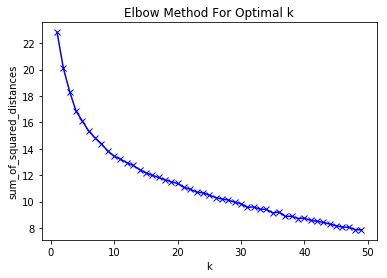

In [0]:
plt.plot(K, sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('sum_of_squared_distances')
plt.title('Elbow Method For Optimal k');

As evident, Elbow method does not seem to help us to determine the optimal number of clusters. We can use another method like the Silhouette method.

"The silhouette value measures how similar a point is to its own cluster (cohesion) compared to other clusters (separation)" (Wikipedia)

In [0]:
from sklearn.metrics import silhouette_score

sil = []
K_sil = range(2,50)
# minimum 2 clusters required, to define dissimilarity
for k in K_sil:
    print(k, end=' ')
    kmeans = KMeans(n_clusters = k).fit(nyc_grouped_clustering)
    labels = kmeans.labels_
    sil.append(silhouette_score(nyc_grouped_clustering, labels, metric = 'euclidean'))

2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 

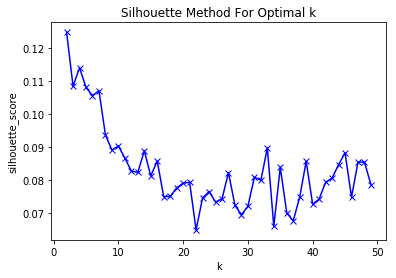

In [0]:
plt.plot(K_sil, sil, 'bx-')
plt.xlabel('k')
plt.ylabel('silhouette_score')
plt.title('Silhouette Method For Optimal k')
plt.show()

There is a peak at \
k = 2, \
k = 4 and \
k = 8. \
Two and four clusters will give a very broad classification of the venues.

###### Setting the number of clusters to 8

In [0]:
kclusters = 8

# run k-means clustering
kmeans = KMeans(init="k-means++", n_clusters=kclusters, n_init=50).fit(nyc_grouped_clustering)

print(Counter(kmeans.labels_))

Counter({4: 57, 2: 55, 6: 54, 5: 51, 7: 33, 1: 26, 0: 22, 3: 4})


A new dataframe will be created that includes the cluster as well as the top 5 venues for each neighborhood.

In [0]:
# adding clustering labels
try:
    neighborhoods_venues_sorted.drop('Cluster Labels', axis=1)
except:
    neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

In [0]:
neighborhoods_venues_sorted.head(5)

,Cluster Labels,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,7,Allerton,Chinese Restaurant,Pizza Place,Mexican Restaurant,Fast Food Restaurant,Caribbean Restaurant
1,5,Annadale,Pizza Place,Sushi Restaurant,American Restaurant,Italian Restaurant,Japanese Restaurant
2,5,Arden Heights,Pizza Place,American Restaurant,Italian Restaurant,Sushi Restaurant,Mexican Restaurant
3,4,Arlington,Pizza Place,Peruvian Restaurant,American Restaurant,Fast Food Restaurant,Spanish Restaurant
4,2,Arrochar,Italian Restaurant,Pizza Place,Chinese Restaurant,Steakhouse,Middle Eastern Restaurant


In [0]:
# merging the neighborhoods_venues_sorted with nyc_data to add latitude/longitude for each neighborhood
nyc_merged = neighborhoods_venues_sorted.join(neighborhoods.set_index('Neighborhood'), on='Neighborhood')
nyc_merged.head()

,Cluster Labels,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,Borough,Latitude,Longitude
0,7,Allerton,Chinese Restaurant,Pizza Place,Mexican Restaurant,Fast Food Restaurant,Caribbean Restaurant,Bronx,40.865788,-73.859319
1,5,Annadale,Pizza Place,Sushi Restaurant,American Restaurant,Italian Restaurant,Japanese Restaurant,Staten Island,40.538114,-74.178549
2,5,Arden Heights,Pizza Place,American Restaurant,Italian Restaurant,Sushi Restaurant,Mexican Restaurant,Staten Island,40.549286,-74.185887
3,4,Arlington,Pizza Place,Peruvian Restaurant,American Restaurant,Fast Food Restaurant,Spanish Restaurant,Staten Island,40.635325,-74.165104
4,2,Arrochar,Italian Restaurant,Pizza Place,Chinese Restaurant,Steakhouse,Middle Eastern Restaurant,Staten Island,40.596313,-74.067124


Visualizing the resulting clusters

In [0]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=10)

# set color scheme for the clusters
colors_array = cm.rainbow(np.linspace(0, 1, kclusters))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(nyc_merged['Latitude'], nyc_merged['Longitude'], nyc_merged['Neighborhood'], nyc_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

Results of the data analysis will be shown now

## Results

In [0]:
required_column_indices = [2,3,7]
required_column = [list(nyc_merged.columns.values)[i] for i in required_column_indices]
required_column_indices = [2,3,7]

#### Cluster 0 Results 

In [0]:
cluster_0 = nyc_merged.loc[nyc_merged['Cluster Labels'] == 0, nyc_merged.columns[1:12]]
cluster_0.head(5)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,Borough,Latitude,Longitude
29,Breezy Point,American Restaurant,Pizza Place,Yemeni Restaurant,Himalayan Restaurant,Fast Food Restaurant,Queens,40.557401,-73.925512
35,Brooklyn Heights,Pizza Place,American Restaurant,Ramen Restaurant,French Restaurant,Korean Restaurant,Brooklyn,40.695864,-73.993782
44,Carroll Gardens,Pizza Place,Ramen Restaurant,French Restaurant,Seafood Restaurant,BBQ Joint,Brooklyn,40.680540,-73.994654
55,Clason Point,American Restaurant,Seafood Restaurant,South American Restaurant,Hawaiian Restaurant,English Restaurant,Bronx,40.806551,-73.854144
60,Cobble Hill,French Restaurant,Pizza Place,Korean Restaurant,American Restaurant,Japanese Restaurant,Brooklyn,40.687920,-73.998561


In [0]:
for col in required_column:
    print(cluster_0[col].value_counts(ascending = False))
    print("---------------------------------------------")

Pizza Place            12
American Restaurant     8
French Restaurant       1
Seafood Restaurant      1
Name: 1st Most Common Venue, dtype: int64
---------------------------------------------
American Restaurant         8
Pizza Place                 6
French Restaurant           1
Seafood Restaurant          1
BBQ Joint                   1
Mediterranean Restaurant    1
Mexican Restaurant          1
Italian Restaurant          1
Ramen Restaurant            1
Fast Food Restaurant        1
Name: 2nd Most Common Venue, dtype: int64
---------------------------------------------
Brooklyn         11
Manhattan         5
Staten Island     3
Queens            2
Bronx             1
Name: Borough, dtype: int64
---------------------------------------------


#### Cluster 1 Results

In [0]:
cluster_1 = nyc_merged.loc[nyc_merged['Cluster Labels'] == 1, nyc_merged.columns[1:12]]
cluster_1.head(5)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,Borough,Latitude,Longitude
36,Brookville,Fried Chicken Joint,Caribbean Restaurant,Pizza Place,Chinese Restaurant,Fast Food Restaurant,Queens,40.660003,-73.751753
41,Cambria Heights,Caribbean Restaurant,Fried Chicken Joint,Chinese Restaurant,Seafood Restaurant,Mexican Restaurant,Queens,40.692775,-73.735269
42,Canarsie,Caribbean Restaurant,Fast Food Restaurant,Chinese Restaurant,Pizza Place,Fried Chicken Joint,Brooklyn,40.635564,-73.902093
68,Crown Heights,Caribbean Restaurant,Fast Food Restaurant,Southern / Soul Food Restaurant,Fried Chicken Joint,Mexican Restaurant,Brooklyn,40.670829,-73.943291
77,East Flatbush,Caribbean Restaurant,Chinese Restaurant,Fried Chicken Joint,Pizza Place,Fast Food Restaurant,Brooklyn,40.641718,-73.936103


In [0]:
for col in required_column:
    print(cluster_1[col].value_counts(ascending = False))
    print("---------------------------------------------")

Caribbean Restaurant               23
Fried Chicken Joint                 1
Pizza Place                         1
Southern / Soul Food Restaurant     1
Name: 1st Most Common Venue, dtype: int64
---------------------------------------------
Fast Food Restaurant    8
Pizza Place             7
Chinese Restaurant      6
Caribbean Restaurant    3
Indian Restaurant       1
Fried Chicken Joint     1
Name: 2nd Most Common Venue, dtype: int64
---------------------------------------------
Brooklyn    12
Queens       9
Bronx        5
Name: Borough, dtype: int64
---------------------------------------------


#### Cluster 2 Results 

In [0]:
cluster_2 = nyc_merged.loc[nyc_merged['Cluster Labels'] == 2, nyc_merged.columns[1:12]]
cluster_2.head(5)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,Borough,Latitude,Longitude
4,Arrochar,Italian Restaurant,Pizza Place,Chinese Restaurant,Steakhouse,Middle Eastern Restaurant,Staten Island,40.596313,-74.067124
7,Astoria Heights,Italian Restaurant,Pizza Place,Chinese Restaurant,Greek Restaurant,Sushi Restaurant,Queens,40.770317,-73.894680
10,Battery Park City,Fast Food Restaurant,Pizza Place,Mexican Restaurant,Seafood Restaurant,Italian Restaurant,Manhattan,40.711932,-74.016869
12,Bay Terrace,Italian Restaurant,Pizza Place,American Restaurant,Chinese Restaurant,Asian Restaurant,Queens,40.782843,-73.776802
12,Bay Terrace,Italian Restaurant,Pizza Place,American Restaurant,Chinese Restaurant,Asian Restaurant,Staten Island,40.553988,-74.139166


In [0]:
for col in required_column:
    print(cluster_2[col].value_counts(ascending = False))
    print("---------------------------------------------")

Italian Restaurant      24
Pizza Place             12
Mexican Restaurant       4
Fast Food Restaurant     4
American Restaurant      3
Chinese Restaurant       3
Seafood Restaurant       2
Asian Restaurant         1
Steakhouse               1
Sushi Restaurant         1
Taco Place               1
Fried Chicken Joint      1
Name: 1st Most Common Venue, dtype: int64
---------------------------------------------
Pizza Place                  16
Italian Restaurant           15
Mexican Restaurant            5
Fast Food Restaurant          5
Chinese Restaurant            4
American Restaurant           3
Vietnamese Restaurant         1
Seafood Restaurant            1
Korean Restaurant             1
Middle Eastern Restaurant     1
New American Restaurant       1
Sushi Restaurant              1
Thai Restaurant               1
BBQ Joint                     1
Japanese Restaurant           1
Name: 2nd Most Common Venue, dtype: int64
---------------------------------------------
Staten Island    16


#### Cluster 3 Results 

In [0]:
cluster_3 = nyc_merged.loc[nyc_merged['Cluster Labels'] == 3, nyc_merged.columns[1:12]]
cluster_3.head(4)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,Borough,Latitude,Longitude
40,Butler Manor,Italian Restaurant,Asian Restaurant,Fried Chicken Joint,BBQ Joint,Chinese Restaurant,Staten Island,40.506082,-74.229504
152,Lighthouse Hill,Italian Restaurant,Yemeni Restaurant,Himalayan Restaurant,Falafel Restaurant,Fast Food Restaurant,Staten Island,40.576506,-74.137927
230,Richmond Town,Italian Restaurant,Asian Restaurant,Mexican Restaurant,Pizza Place,Fast Food Restaurant,Staten Island,40.569606,-74.134057
271,Tottenville,Italian Restaurant,Mexican Restaurant,Asian Restaurant,Pizza Place,Chinese Restaurant,Staten Island,40.505334,-74.246569


In [0]:
for col in required_column:
    print(cluster_3[col].value_counts(ascending = False))
    print("---------------------------------------------")

Italian Restaurant    4
Name: 1st Most Common Venue, dtype: int64
---------------------------------------------
Asian Restaurant      2
Yemeni Restaurant     1
Mexican Restaurant    1
Name: 2nd Most Common Venue, dtype: int64
---------------------------------------------
Staten Island    4
Name: Borough, dtype: int64
---------------------------------------------


#### Cluster 4 Results 

In [0]:
cluster_4 = nyc_merged.loc[nyc_merged['Cluster Labels'] == 4, nyc_merged.columns[1:12]]
cluster_4.head(5)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,Borough,Latitude,Longitude
3,Arlington,Pizza Place,Peruvian Restaurant,American Restaurant,Fast Food Restaurant,Spanish Restaurant,Staten Island,40.635325,-74.165104
6,Astoria,Fast Food Restaurant,Pizza Place,Ramen Restaurant,Italian Restaurant,Middle Eastern Restaurant,Queens,40.768509,-73.915654
11,Bay Ridge,Pizza Place,Fast Food Restaurant,Middle Eastern Restaurant,Mexican Restaurant,Fried Chicken Joint,Brooklyn,40.625801,-74.030621
17,Bedford Stuyvesant,Fried Chicken Joint,Fast Food Restaurant,Pizza Place,New American Restaurant,Southern / Soul Food Restaurant,Brooklyn,40.687232,-73.941785
27,Boerum Hill,Pizza Place,Fast Food Restaurant,Mediterranean Restaurant,French Restaurant,BBQ Joint,Brooklyn,40.685683,-73.983748


In [0]:
for col in required_column:
    print(cluster_4[col].value_counts(ascending = False))
    print("---------------------------------------------")

Pizza Place             31
Fast Food Restaurant    21
Fried Chicken Joint      4
Taco Place               1
Name: 1st Most Common Venue, dtype: int64
---------------------------------------------
Fast Food Restaurant       20
Pizza Place                17
Fried Chicken Joint         8
Mexican Restaurant          2
American Restaurant         2
Spanish Restaurant          2
Italian Restaurant          1
Steakhouse                  1
New American Restaurant     1
Peruvian Restaurant         1
Korean Restaurant           1
Chinese Restaurant          1
Name: 2nd Most Common Venue, dtype: int64
---------------------------------------------
Bronx            17
Brooklyn         15
Queens           11
Manhattan        11
Staten Island     3
Name: Borough, dtype: int64
---------------------------------------------


#### Cluster 5 Results

In [0]:
cluster_5 = nyc_merged.loc[nyc_merged['Cluster Labels'] == 5, nyc_merged.columns[1:12]]
cluster_5.head(5)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,Borough,Latitude,Longitude
1,Annadale,Pizza Place,Sushi Restaurant,American Restaurant,Italian Restaurant,Japanese Restaurant,Staten Island,40.538114,-74.178549
2,Arden Heights,Pizza Place,American Restaurant,Italian Restaurant,Sushi Restaurant,Mexican Restaurant,Staten Island,40.549286,-74.185887
21,Bellerose,Pizza Place,Indian Restaurant,Chinese Restaurant,American Restaurant,Fast Food Restaurant,Queens,40.728573,-73.720128
26,Bloomfield,Pizza Place,Mexican Restaurant,Italian Restaurant,BBQ Joint,Yemeni Restaurant,Staten Island,40.605779,-74.187256
34,Bronxdale,Pizza Place,Italian Restaurant,Mexican Restaurant,Yemeni Restaurant,Seafood Restaurant,Bronx,40.852723,-73.861726


In [0]:
for col in required_column:
    print(cluster_5[col].value_counts(ascending = False))
    print("---------------------------------------------")

Pizza Place           49
Mexican Restaurant     1
Italian Restaurant     1
Name: 1st Most Common Venue, dtype: int64
---------------------------------------------
Italian Restaurant      11
American Restaurant      9
Chinese Restaurant       8
Mexican Restaurant       4
Caribbean Restaurant     3
Japanese Restaurant      3
Fast Food Restaurant     3
Indian Restaurant        2
Sushi Restaurant         2
Spanish Restaurant       1
Pizza Place              1
Kosher Restaurant        1
BBQ Joint                1
Taco Place               1
Asian Restaurant         1
Name: 2nd Most Common Venue, dtype: int64
---------------------------------------------
Staten Island    27
Queens           13
Bronx             6
Brooklyn          4
Manhattan         1
Name: Borough, dtype: int64
---------------------------------------------


#### Cluster 6 Results 

In [0]:
cluster_6 = nyc_merged.loc[nyc_merged['Cluster Labels'] == 6, nyc_merged.columns[1:12]]
cluster_6.head(5)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,Borough,Latitude,Longitude
8,Auburndale,Korean Restaurant,Pizza Place,Greek Restaurant,Italian Restaurant,Chinese Restaurant,Queens,40.761730,-73.791762
9,Bath Beach,Cantonese Restaurant,Chinese Restaurant,Vietnamese Restaurant,Fast Food Restaurant,Pizza Place,Brooklyn,40.599519,-73.998752
14,Bayside,Korean Restaurant,Pizza Place,Fast Food Restaurant,Asian Restaurant,Thai Restaurant,Queens,40.766041,-73.774274
23,Bensonhurst,Cantonese Restaurant,Chinese Restaurant,Asian Restaurant,Italian Restaurant,Sushi Restaurant,Brooklyn,40.611009,-73.995180
25,Blissville,Pizza Place,Chinese Restaurant,Mexican Restaurant,Italian Restaurant,Fast Food Restaurant,Queens,40.737251,-73.932442


In [0]:
for col in required_column:
    print(cluster_6[col].value_counts(ascending = False))
    print("---------------------------------------------")

Pizza Place                    22
Fast Food Restaurant            6
Mexican Restaurant              5
Korean Restaurant               5
Indian Restaurant               4
Chinese Restaurant              4
Cantonese Restaurant            2
Latin American Restaurant       2
Spanish Restaurant              1
Seafood Restaurant              1
New American Restaurant         1
Fried Chicken Joint             1
Sushi Restaurant                1
Eastern European Restaurant     1
Name: 1st Most Common Venue, dtype: int64
---------------------------------------------
Chinese Restaurant               16
Pizza Place                       9
Fast Food Restaurant              7
Mexican Restaurant                3
Caribbean Restaurant              2
Fried Chicken Joint               2
Thai Restaurant                   2
Italian Restaurant                2
Japanese Restaurant               2
Seafood Restaurant                1
Indian Restaurant                 1
Middle Eastern Restaurant         1
Span

#### Cluster 7 Results 

In [0]:
cluster_7 = nyc_merged.loc[nyc_merged['Cluster Labels'] == 7, nyc_merged.columns[1:12]]
cluster_7.head(5)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,Borough,Latitude,Longitude
0,Allerton,Chinese Restaurant,Pizza Place,Mexican Restaurant,Fast Food Restaurant,Caribbean Restaurant,Bronx,40.865788,-73.859319
5,Arverne,Chinese Restaurant,Pizza Place,Thai Restaurant,American Restaurant,Asian Restaurant,Queens,40.589144,-73.791992
13,Baychester,Pizza Place,Chinese Restaurant,Seafood Restaurant,BBQ Joint,Caribbean Restaurant,Bronx,40.866858,-73.835798
15,Bayswater,Chinese Restaurant,Fast Food Restaurant,Fried Chicken Joint,Pizza Place,Caribbean Restaurant,Queens,40.611322,-73.765968
16,Bedford Park,Pizza Place,Chinese Restaurant,Fast Food Restaurant,Mexican Restaurant,Fried Chicken Joint,Bronx,40.870185,-73.885512


In [0]:
for col in required_column:
    print(cluster_7[col].value_counts(ascending = False))
    print("---------------------------------------------")

Chinese Restaurant      16
Pizza Place             15
Fast Food Restaurant     2
Name: 1st Most Common Venue, dtype: int64
---------------------------------------------
Chinese Restaurant      15
Pizza Place             10
Fast Food Restaurant     3
Fried Chicken Joint      2
Caribbean Restaurant     2
American Restaurant      1
Name: 2nd Most Common Venue, dtype: int64
---------------------------------------------
Queens           14
Bronx             9
Brooklyn          6
Staten Island     4
Name: Borough, dtype: int64
---------------------------------------------


## Discussion

K-mean clustering algorithm is used to segment New York City’s neighbourhoods. The optimal number of clusters is eight for this project as found out through ‘The Silhouette Method.’ Each of these clusters is analysed through determining the borough count, count of ‘First Most Common Venue’ and ‘Second Most Common Venue.’ 

As evident from the results that pizza is the most common food in New York City. Since it is considered as go-to food, we can set it aside and regard Italian food as the most common cuisine. Caribbean, Chinese, Asian and American foods are also common in different areas. 

## Conslusion

This project is aimed at exploring the boroughs of New York City to locate the most common food options in different neighbourhoods. Data is collected from ‘New York City Dataset’ and it is processed and cleaned through different python libraries. K-mean clustering algorithm is used to segment the data into clusters and after analysis, we find out the most common cuisines in different parts of the city. Pizza is the most common food but keeping in view the ubiquitous nature of this and other fast foods, it is set aside, and conclusion is drawn on the basis of most common foods next to pizza. It is evident from the analysis that American, Italian, Caribbean, Chinese and Asian cuisines are most common in the city.


Since this project used a dataset from 2018, the results can be improved by compiling a dataset based on the recent data. Detailed information can also be gained through exploring individual cuisines and boroughs by compiling a dataset through the Foursquare API. In this way, highly rated restaurants for a particular cuisine in a borough can be highlighted which will help the locals and tourists to make informed decision. 
